In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 832)
(663976, 1)
validation
(128936, 832)
(128936, 1)
test
(61376, 832)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:41 - loss: 0.0127 - STD: 2.2666e-04 - MAE: 0.0822

 4/67 [>.............................] - ETA: 1s - loss: 0.0168 - STD: 3.9786e-04 - MAE: 0.1012  

 7/67 [==>...........................] - ETA: 1s - loss: 0.0173 - STD: 4.5492e-04 - MAE: 0.0998

10/67 [===>..........................] - ETA: 1s - loss: 0.0159 - STD: 5.7458e-04 - MAE: 0.0957

13/67 [====>.........................] - ETA: 1s - loss: 0.0154 - STD: 7.0285e-04 - MAE: 0.0967

16/67 [======>.......................] - ETA: 1s - loss: 0.0147 - STD: 7.8408e-04 - MAE: 0.0945

19/67 [=======>......................] - ETA: 1s - loss: 0.0144 - STD: 8.3365e-04 - MAE: 0.0927

22/67 [========>.....................] - ETA: 1s - loss: 0.0140 - STD: 8.9497e-04 - MAE: 0.0912

25/67 [==========>...................] - ETA: 0s - loss: 0.0137 - STD: 9.8133e-04 - MAE: 0.0907

28/67 [===========>..................] - ETA: 0s - loss: 0.0135 - STD: 0.0011 - MAE: 0.0904    

31/67 [============>.................] - ETA: 0s - loss: 0.0133 - STD: 0.0012 - MAE: 0.0897

34/67 [==============>...............] - ETA: 0s - loss: 0.0131 - STD: 0.0012 - MAE: 0.0890

37/67 [===============>..............] - ETA: 0s - loss: 0.0130 - STD: 0.0013 - MAE: 0.0885

40/67 [================>.............] - ETA: 0s - loss: 0.0129 - STD: 0.0015 - MAE: 0.0883

43/67 [==================>...........] - ETA: 0s - loss: 0.0128 - STD: 0.0016 - MAE: 0.0881

46/67 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 0.0018 - MAE: 0.0876

49/67 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 0.0019 - MAE: 0.0873

52/67 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0022 - MAE: 0.0871

55/67 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.0025 - MAE: 0.0869

58/67 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0866

61/67 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 0.0032 - MAE: 0.0863

64/67 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 0.0037 - MAE: 0.0860

67/67 [==============================] - ETA: 0s - loss: 0.0120 - STD: 0.0043 - MAE: 0.0857

67/67 [==============================] - 5s 46ms/step - loss: 0.0120 - STD: 0.0043 - MAE: 0.0857 - val_loss: 0.0088 - val_STD: 0.0143 - val_MAE: 0.0750


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0100 - STD: 0.0201 - MAE: 0.0784

 4/67 [>.............................] - ETA: 1s - loss: 0.0099 - STD: 0.0224 - MAE: 0.0779

 7/67 [==>...........................] - ETA: 1s - loss: 0.0098 - STD: 0.0252 - MAE: 0.0780

10/67 [===>..........................] - ETA: 1s - loss: 0.0097 - STD: 0.0279 - MAE: 0.0777

13/67 [====>.........................] - ETA: 1s - loss: 0.0097 - STD: 0.0305 - MAE: 0.0773

16/67 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 0.0330 - MAE: 0.0767

19/67 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 0.0352 - MAE: 0.0764

22/67 [========>.....................] - ETA: 0s - loss: 0.0094 - STD: 0.0369 - MAE: 0.0761

25/67 [==========>...................] - ETA: 0s - loss: 0.0094 - STD: 0.0382 - MAE: 0.0757

28/67 [===========>..................] - ETA: 0s - loss: 0.0093 - STD: 0.0392 - MAE: 0.0754

31/67 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 0.0400 - MAE: 0.0750

34/67 [==============>...............] - ETA: 0s - loss: 0.0091 - STD: 0.0407 - MAE: 0.0748

37/67 [===============>..............] - ETA: 0s - loss: 0.0091 - STD: 0.0413 - MAE: 0.0745

40/67 [================>.............] - ETA: 0s - loss: 0.0090 - STD: 0.0421 - MAE: 0.0743

43/67 [==================>...........] - ETA: 0s - loss: 0.0090 - STD: 0.0428 - MAE: 0.0740

46/67 [===================>..........] - ETA: 0s - loss: 0.0089 - STD: 0.0436 - MAE: 0.0737

48/67 [====================>.........] - ETA: 0s - loss: 0.0089 - STD: 0.0441 - MAE: 0.0735

51/67 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0448 - MAE: 0.0733

54/67 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0453 - MAE: 0.0730

57/67 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0459 - MAE: 0.0727

60/67 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0464 - MAE: 0.0725

63/67 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0469 - MAE: 0.0722

66/67 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0475 - MAE: 0.0719

67/67 [==============================] - 2s 27ms/step - loss: 0.0085 - STD: 0.0477 - MAE: 0.0718 - val_loss: 0.0059 - val_STD: 0.0483 - val_MAE: 0.0601


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0071 - STD: 0.0627 - MAE: 0.0660

 4/67 [>.............................] - ETA: 1s - loss: 0.0073 - STD: 0.0628 - MAE: 0.0658

 7/67 [==>...........................] - ETA: 1s - loss: 0.0073 - STD: 0.0633 - MAE: 0.0656

10/67 [===>..........................] - ETA: 1s - loss: 0.0072 - STD: 0.0638 - MAE: 0.0655

13/67 [====>.........................] - ETA: 1s - loss: 0.0072 - STD: 0.0641 - MAE: 0.0653

16/67 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0643 - MAE: 0.0650

19/67 [=======>......................] - ETA: 1s - loss: 0.0071 - STD: 0.0647 - MAE: 0.0649

22/67 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.0646 - MAE: 0.0649

25/67 [==========>...................] - ETA: 0s - loss: 0.0071 - STD: 0.0647 - MAE: 0.0648

28/67 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0647 - MAE: 0.0647

31/67 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.0647 - MAE: 0.0646

34/67 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0648 - MAE: 0.0645

37/67 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0648 - MAE: 0.0644

40/67 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.0649 - MAE: 0.0643

43/67 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0650 - MAE: 0.0643

46/67 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0651 - MAE: 0.0642

49/67 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0652 - MAE: 0.0641

52/67 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0654 - MAE: 0.0641

55/67 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0655 - MAE: 0.0640

58/67 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0656 - MAE: 0.0640

61/67 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0656 - MAE: 0.0639

64/67 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0657 - MAE: 0.0638

67/67 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0658 - MAE: 0.0638

67/67 [==============================] - 2s 27ms/step - loss: 0.0069 - STD: 0.0658 - MAE: 0.0638 - val_loss: 0.0056 - val_STD: 0.0528 - val_MAE: 0.0565


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0067 - STD: 0.0665 - MAE: 0.0618

 4/67 [>.............................] - ETA: 1s - loss: 0.0069 - STD: 0.0679 - MAE: 0.0633

 7/67 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0678 - MAE: 0.0628

10/67 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0677 - MAE: 0.0626

13/67 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0674 - MAE: 0.0624

16/67 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.0672 - MAE: 0.0625

19/67 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.0674 - MAE: 0.0626

22/67 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0674 - MAE: 0.0625

25/67 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0675 - MAE: 0.0624

28/67 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0675 - MAE: 0.0623

31/67 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0676 - MAE: 0.0624

34/67 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0676 - MAE: 0.0624

37/67 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0676 - MAE: 0.0625

40/67 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0675 - MAE: 0.0626

43/67 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0672 - MAE: 0.0629

46/67 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0672 - MAE: 0.0630

49/67 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0670 - MAE: 0.0631

52/67 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0668 - MAE: 0.0631

55/67 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0665 - MAE: 0.0630

58/67 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0665 - MAE: 0.0630

61/67 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0666 - MAE: 0.0630

64/67 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0666 - MAE: 0.0629

67/67 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0667 - MAE: 0.0628

67/67 [==============================] - 2s 27ms/step - loss: 0.0068 - STD: 0.0667 - MAE: 0.0628 - val_loss: 0.0056 - val_STD: 0.0579 - val_MAE: 0.0583


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0632

 4/67 [>.............................] - ETA: 1s - loss: 0.0065 - STD: 0.0691 - MAE: 0.0613

 7/67 [==>...........................] - ETA: 1s - loss: 0.0065 - STD: 0.0693 - MAE: 0.0613

10/67 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0699 - MAE: 0.0614

13/67 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0701 - MAE: 0.0614

15/67 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0700 - MAE: 0.0614

18/67 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0700 - MAE: 0.0612

21/67 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0700 - MAE: 0.0612

24/67 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0700 - MAE: 0.0612

27/67 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0612

30/67 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0612

33/67 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0612

36/67 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0612

39/67 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0612

42/67 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0702 - MAE: 0.0612

45/67 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0702 - MAE: 0.0611

48/67 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0702 - MAE: 0.0611

51/67 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0611

54/67 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0611

57/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0611

60/67 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0610

63/67 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0611

66/67 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0611

67/67 [==============================] - 2s 27ms/step - loss: 0.0064 - STD: 0.0703 - MAE: 0.0610 - val_loss: 0.0056 - val_STD: 0.0602 - val_MAE: 0.0591


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0067 - STD: 0.0748 - MAE: 0.0643

 4/67 [>.............................] - ETA: 1s - loss: 0.0065 - STD: 0.0707 - MAE: 0.0621

 7/67 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0702 - MAE: 0.0619

10/67 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0700 - MAE: 0.0620

13/67 [====>.........................] - ETA: 1s - loss: 0.0066 - STD: 0.0696 - MAE: 0.0620

16/67 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0693 - MAE: 0.0619

19/67 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0693 - MAE: 0.0619

22/67 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0616

25/67 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0615

28/67 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0614

31/67 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0613

34/67 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0693 - MAE: 0.0612

37/67 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0611

40/67 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610

43/67 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0697 - MAE: 0.0610

46/67 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0698 - MAE: 0.0610

49/67 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0699 - MAE: 0.0609

52/67 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0700 - MAE: 0.0609

55/67 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0608

58/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0702 - MAE: 0.0608

61/67 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0703 - MAE: 0.0608

64/67 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0607

67/67 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0607

67/67 [==============================] - 2s 27ms/step - loss: 0.0064 - STD: 0.0704 - MAE: 0.0607 - val_loss: 0.0055 - val_STD: 0.0605 - val_MAE: 0.0573


Epoch 7/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0746 - MAE: 0.0624

 4/67 [>.............................] - ETA: 1s - loss: 0.0063 - STD: 0.0728 - MAE: 0.0610

 7/67 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0723 - MAE: 0.0606

10/67 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0721 - MAE: 0.0603

13/67 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0720 - MAE: 0.0604

16/67 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0720 - MAE: 0.0603

19/67 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0718 - MAE: 0.0602

22/67 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0717 - MAE: 0.0601

25/67 [==========>...................] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0601

28/67 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0601

31/67 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0600

34/67 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0599

37/67 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0600

40/67 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0600

43/67 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0719 - MAE: 0.0600

46/67 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0599

49/67 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0599

52/67 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0600

55/67 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0600

58/67 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0599

61/67 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0718 - MAE: 0.0599

64/67 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0600

67/67 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0717 - MAE: 0.0600

67/67 [==============================] - 2s 26ms/step - loss: 0.0062 - STD: 0.0717 - MAE: 0.0600 - val_loss: 0.0055 - val_STD: 0.0611 - val_MAE: 0.0584


Epoch 8/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0750 - MAE: 0.0632

 4/67 [>.............................] - ETA: 1s - loss: 0.0064 - STD: 0.0718 - MAE: 0.0617

 7/67 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0705 - MAE: 0.0611

10/67 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0609

13/67 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0609

16/67 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0609

19/67 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0704 - MAE: 0.0609

22/67 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0702 - MAE: 0.0611

25/67 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0700 - MAE: 0.0615

28/67 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0698 - MAE: 0.0617

31/67 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0695 - MAE: 0.0619

34/67 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0690 - MAE: 0.0619

37/67 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0686 - MAE: 0.0618

40/67 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0685 - MAE: 0.0618

43/67 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0684 - MAE: 0.0618

46/67 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0683 - MAE: 0.0616

49/67 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0684 - MAE: 0.0615

52/67 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0686 - MAE: 0.0614

55/67 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0688 - MAE: 0.0613

58/67 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0690 - MAE: 0.0612

61/67 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0692 - MAE: 0.0611

64/67 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0694 - MAE: 0.0611

67/67 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610

67/67 [==============================] - 2s 27ms/step - loss: 0.0064 - STD: 0.0695 - MAE: 0.0610 - val_loss: 0.0053 - val_STD: 0.0603 - val_MAE: 0.0559


Epoch 9/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0745 - MAE: 0.0600

 4/67 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0591

 7/67 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0590

10/67 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0591

13/67 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0592

16/67 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0592

19/67 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0593

22/67 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0593

25/67 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0727 - MAE: 0.0592

28/67 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0592

31/67 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0726 - MAE: 0.0592

34/67 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0727 - MAE: 0.0592

37/67 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0592

40/67 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0591

43/67 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0591

46/67 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0591

49/67 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0591

52/67 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0591

55/67 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0728 - MAE: 0.0590

58/67 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0591

61/67 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0590

64/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0729 - MAE: 0.0590

67/67 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0730 - MAE: 0.0590

67/67 [==============================] - 2s 27ms/step - loss: 0.0060 - STD: 0.0730 - MAE: 0.0590 - val_loss: 0.0053 - val_STD: 0.0598 - val_MAE: 0.0546


Epoch 10/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0734 - MAE: 0.0589

 4/67 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0589

 7/67 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0735 - MAE: 0.0585

10/67 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0586

13/67 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0738 - MAE: 0.0584

16/67 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0584

19/67 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0584

22/67 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0585

24/67 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0739 - MAE: 0.0586

26/67 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0739 - MAE: 0.0586

29/67 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0586

32/67 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0586

35/67 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0738 - MAE: 0.0586

38/67 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0586

41/67 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0586

44/67 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0586

47/67 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0737 - MAE: 0.0586

50/67 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

53/67 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

56/67 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

59/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

62/67 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0736 - MAE: 0.0586

65/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0735 - MAE: 0.0587

67/67 [==============================] - 2s 27ms/step - loss: 0.0060 - STD: 0.0735 - MAE: 0.0587 - val_loss: 0.0057 - val_STD: 0.0538 - val_MAE: 0.0545


Epoch 11/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0586

 4/67 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0711 - MAE: 0.0584

 6/67 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0716 - MAE: 0.0583

 9/67 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0717 - MAE: 0.0582

12/67 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0719 - MAE: 0.0584

15/67 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0722 - MAE: 0.0583

18/67 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0724 - MAE: 0.0583

21/67 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0583

24/67 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0727 - MAE: 0.0583

27/67 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0582

30/67 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0731 - MAE: 0.0582

33/67 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0583

36/67 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0584

39/67 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0583

42/67 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0583

45/67 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0583

48/67 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0583

51/67 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0583

54/67 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0735 - MAE: 0.0584

57/67 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0584

60/67 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0734 - MAE: 0.0585

63/67 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0734 - MAE: 0.0585

66/67 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0733 - MAE: 0.0585

67/67 [==============================] - 2s 27ms/step - loss: 0.0060 - STD: 0.0734 - MAE: 0.0586 - val_loss: 0.0053 - val_STD: 0.0570 - val_MAE: 0.0538


Epoch 12/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0571

 4/67 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0714 - MAE: 0.0581

 6/67 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0718 - MAE: 0.0582

 9/67 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0718 - MAE: 0.0584

11/67 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0720 - MAE: 0.0584

14/67 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0723 - MAE: 0.0582

17/67 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0725 - MAE: 0.0581

20/67 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0580

23/67 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0579

26/67 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0579

29/67 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0731 - MAE: 0.0579

32/67 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0578

35/67 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0578

38/67 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0578

41/67 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0735 - MAE: 0.0578

44/67 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0736 - MAE: 0.0578

47/67 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0579

50/67 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

53/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0578

56/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0579

59/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0579

62/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0579

65/67 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0579

67/67 [==============================] - 2s 28ms/step - loss: 0.0059 - STD: 0.0739 - MAE: 0.0579 - val_loss: 0.0052 - val_STD: 0.0621 - val_MAE: 0.0550


Epoch 13/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0585

 4/67 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0579

 7/67 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0744 - MAE: 0.0576

 9/67 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0575

11/67 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0740 - MAE: 0.0577

14/67 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0741 - MAE: 0.0578

17/67 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0578

20/67 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0577

23/67 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0577

26/67 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0577

29/67 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0577

32/67 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0576

35/67 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0744 - MAE: 0.0577

38/67 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0576

41/67 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0576

44/67 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0576

47/67 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0576

50/67 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0576

53/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0576

56/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0577

59/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0577

62/67 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0744 - MAE: 0.0577

65/67 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0577

67/67 [==============================] - 2s 27ms/step - loss: 0.0058 - STD: 0.0743 - MAE: 0.0577 - val_loss: 0.0052 - val_STD: 0.0583 - val_MAE: 0.0531


Epoch 14/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0723 - MAE: 0.0558

 4/67 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0740 - MAE: 0.0582

 7/67 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0737 - MAE: 0.0581

10/67 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0734 - MAE: 0.0579

13/67 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0737 - MAE: 0.0575

16/67 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0575

19/67 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0738 - MAE: 0.0574

22/67 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0739 - MAE: 0.0574

25/67 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0742 - MAE: 0.0575

28/67 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0574

31/67 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0743 - MAE: 0.0574

34/67 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0745 - MAE: 0.0574

37/67 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0573

40/67 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

42/67 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

45/67 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

48/67 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

51/67 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0747 - MAE: 0.0574

54/67 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0747 - MAE: 0.0574

57/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

60/67 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

63/67 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

66/67 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0746 - MAE: 0.0574

67/67 [==============================] - 2s 27ms/step - loss: 0.0058 - STD: 0.0745 - MAE: 0.0574 - val_loss: 0.0051 - val_STD: 0.0623 - val_MAE: 0.0543


Epoch 15/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0569

 4/67 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0754 - MAE: 0.0570

 7/67 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0748 - MAE: 0.0570

10/67 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0748 - MAE: 0.0569

13/67 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0750 - MAE: 0.0569

16/67 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0569

19/67 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0571

22/67 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0752 - MAE: 0.0572

25/67 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0572

28/67 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

31/67 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0751 - MAE: 0.0571

34/67 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0571

37/67 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0570

40/67 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0569

43/67 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0568

46/67 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0568

49/67 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0568

52/67 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0569

55/67 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0754 - MAE: 0.0569

58/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0569

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0569

64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0752 - MAE: 0.0568

67/67 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0753 - MAE: 0.0568

67/67 [==============================] - 2s 27ms/step - loss: 0.0057 - STD: 0.0753 - MAE: 0.0568 - val_loss: 0.0051 - val_STD: 0.0625 - val_MAE: 0.0531


Epoch 16/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0557

 4/67 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0761 - MAE: 0.0557

 7/67 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0559

10/67 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0763 - MAE: 0.0561

13/67 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0765 - MAE: 0.0563

16/67 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0763 - MAE: 0.0562

19/67 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0562

22/67 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0762 - MAE: 0.0562

25/67 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0762 - MAE: 0.0563

28/67 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0758 - MAE: 0.0567

31/67 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0759 - MAE: 0.0568

34/67 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0758 - MAE: 0.0568

37/67 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0757 - MAE: 0.0568

40/67 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0568

43/67 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0568

46/67 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0568

49/67 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0567

52/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0567

55/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0566

58/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0567

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0756 - MAE: 0.0567

64/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0567

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0566

67/67 [==============================] - 2s 27ms/step - loss: 0.0056 - STD: 0.0755 - MAE: 0.0566 - val_loss: 0.0051 - val_STD: 0.0633 - val_MAE: 0.0539


Epoch 17/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0564

 4/67 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0755 - MAE: 0.0561

 7/67 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0754 - MAE: 0.0561

10/67 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0756 - MAE: 0.0561

13/67 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0564

16/67 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0760 - MAE: 0.0565

19/67 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0565

22/67 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

25/67 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0566

28/67 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0566

31/67 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0566

34/67 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0565

37/67 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0564

40/67 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0564

43/67 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0564

46/67 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0563

49/67 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0563

52/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0563

55/67 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0563

58/67 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0563

61/67 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0563

64/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0564

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0564

67/67 [==============================] - 2s 27ms/step - loss: 0.0056 - STD: 0.0758 - MAE: 0.0564 - val_loss: 0.0055 - val_STD: 0.0589 - val_MAE: 0.0536


Epoch 18/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0717 - MAE: 0.0548

 4/67 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0750 - MAE: 0.0560

 7/67 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0564

10/67 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563

13/67 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0758 - MAE: 0.0562

16/67 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0560

19/67 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0560

22/67 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0560

25/67 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0763 - MAE: 0.0559

28/67 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0559

31/67 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0559

34/67 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0559

37/67 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0558

40/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0559

43/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0763 - MAE: 0.0558

46/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0560

49/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0560

52/67 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0761 - MAE: 0.0561

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

58/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

61/67 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

64/67 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0561

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0759 - MAE: 0.0561

67/67 [==============================] - 2s 27ms/step - loss: 0.0056 - STD: 0.0759 - MAE: 0.0561 - val_loss: 0.0051 - val_STD: 0.0616 - val_MAE: 0.0526


Epoch 19/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0749 - MAE: 0.0551

 4/67 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0751 - MAE: 0.0571

 7/67 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0755 - MAE: 0.0571

10/67 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0757 - MAE: 0.0568

13/67 [====>.........................] - ETA: 1s - loss: 0.0056 - STD: 0.0757 - MAE: 0.0565

16/67 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0756 - MAE: 0.0565

19/67 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0561

22/67 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0757 - MAE: 0.0560

25/67 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0558

28/67 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0557

31/67 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0557

34/67 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0557

37/67 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0762 - MAE: 0.0556

40/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0763 - MAE: 0.0556

43/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0556

46/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0556

49/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0556

52/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0556

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0764 - MAE: 0.0557

58/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0556

61/67 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0556

64/67 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0555

67/67 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0765 - MAE: 0.0555

67/67 [==============================] - 2s 28ms/step - loss: 0.0055 - STD: 0.0765 - MAE: 0.0555 - val_loss: 0.0050 - val_STD: 0.0663 - val_MAE: 0.0537


Epoch 20/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0796 - MAE: 0.0562

 3/67 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0787 - MAE: 0.0563

 6/67 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0782 - MAE: 0.0557

 9/67 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0779 - MAE: 0.0553

12/67 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0553

15/67 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0556

18/67 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0555

21/67 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0554

24/67 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0554

27/67 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0555

30/67 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0556

32/67 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0555

35/67 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0555

38/67 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

41/67 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0554

43/67 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0554

45/67 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0554

48/67 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0553

51/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

58/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0554

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0553

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0770 - MAE: 0.0553

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553

67/67 [==============================] - 2s 28ms/step - loss: 0.0054 - STD: 0.0771 - MAE: 0.0553 - val_loss: 0.0050 - val_STD: 0.0648 - val_MAE: 0.0525


Epoch 21/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0539

 4/67 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0547

 7/67 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0551

10/67 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0774 - MAE: 0.0549

13/67 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0775 - MAE: 0.0549

16/67 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0772 - MAE: 0.0550

19/67 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0550

22/67 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0552

25/67 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0554

28/67 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0773 - MAE: 0.0554

31/67 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0555

34/67 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0768 - MAE: 0.0556

37/67 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0556

40/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0766 - MAE: 0.0556

43/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0766 - MAE: 0.0556

46/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0766 - MAE: 0.0556

49/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0766 - MAE: 0.0556

52/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0766 - MAE: 0.0556

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0556

58/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0767 - MAE: 0.0555

61/67 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0555

67/67 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0767 - MAE: 0.0554

67/67 [==============================] - 2s 27ms/step - loss: 0.0054 - STD: 0.0767 - MAE: 0.0554 - val_loss: 0.0051 - val_STD: 0.0636 - val_MAE: 0.0526


Epoch 22/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0766 - MAE: 0.0540

 3/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0547

 6/67 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0773 - MAE: 0.0546

 9/67 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0547

12/67 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0547

15/67 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0545

18/67 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0545

21/67 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0544

23/67 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0544

26/67 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0544

29/67 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0544

32/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0543

35/67 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0544

38/67 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0548

41/67 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0548

44/67 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0779 - MAE: 0.0548

47/67 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0548

50/67 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0548

53/67 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0547

56/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0547

59/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0547

62/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0547

65/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0547

67/67 [==============================] - 2s 27ms/step - loss: 0.0053 - STD: 0.0778 - MAE: 0.0547 - val_loss: 0.0051 - val_STD: 0.0645 - val_MAE: 0.0526


Epoch 23/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0536

 4/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0542

 7/67 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0545

10/67 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0780 - MAE: 0.0544

13/67 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0543

16/67 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0782 - MAE: 0.0543

18/67 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0544

21/67 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0544

24/67 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0544

27/67 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0544

30/67 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0544

33/67 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0545

36/67 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0544

39/67 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0545

42/67 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0545

45/67 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0545

48/67 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0545

51/67 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0782 - MAE: 0.0544

54/67 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0544

57/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0545

60/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0545

63/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0546

66/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0781 - MAE: 0.0546

67/67 [==============================] - 2s 27ms/step - loss: 0.0053 - STD: 0.0781 - MAE: 0.0546 - val_loss: 0.0054 - val_STD: 0.0607 - val_MAE: 0.0536


Epoch 24/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0537

 4/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0768 - MAE: 0.0544

 7/67 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0542

10/67 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0542

13/67 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0772 - MAE: 0.0543

16/67 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0773 - MAE: 0.0542

19/67 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0774 - MAE: 0.0542

22/67 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0544

25/67 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0544

28/67 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0545

31/67 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0547

34/67 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0547

37/67 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0547

40/67 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0547

43/67 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0547

46/67 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0547

49/67 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0546

52/67 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0546

55/67 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0775 - MAE: 0.0546

58/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0546

61/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0545

64/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0776 - MAE: 0.0545

67/67 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0777 - MAE: 0.0545

67/67 [==============================] - 2s 27ms/step - loss: 0.0053 - STD: 0.0777 - MAE: 0.0545 - val_loss: 0.0051 - val_STD: 0.0635 - val_MAE: 0.0524


Epoch 25/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0770 - MAE: 0.0534

 4/67 [>.............................] - ETA: 1s - loss: 0.0053 - STD: 0.0778 - MAE: 0.0540

 7/67 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0776 - MAE: 0.0538

10/67 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0541

12/67 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0540

15/67 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0783 - MAE: 0.0544

18/67 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

21/67 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

24/67 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0541

27/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0541

30/67 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

32/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

35/67 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

38/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0540

41/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0540

44/67 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0539

47/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0540

50/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

59/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

62/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

65/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

67/67 [==============================] - 2s 27ms/step - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540 - val_loss: 0.0052 - val_STD: 0.0632 - val_MAE: 0.0526


Epoch 26/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0765 - MAE: 0.0527

 4/67 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0540

 7/67 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0536

10/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0535

13/67 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0536

16/67 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0537

19/67 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0539

21/67 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0539

24/67 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0541

27/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0540

29/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

32/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

35/67 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0539

38/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0539

41/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

44/67 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

47/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0538

50/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0540

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

55/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

58/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

61/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

64/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0540

67/67 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540

67/67 [==============================] - 2s 28ms/step - loss: 0.0052 - STD: 0.0785 - MAE: 0.0540 - val_loss: 0.0049 - val_STD: 0.0660 - val_MAE: 0.0519


Epoch 27/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0788 - MAE: 0.0530

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0531

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0530

10/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0533

13/67 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0533

16/67 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0533

19/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0533

22/67 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0537

25/67 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0537

28/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

31/67 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0539

34/67 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0539

36/67 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0539

39/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

41/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

44/67 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

47/67 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

50/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0538

56/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0536

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

67/67 [==============================] - 2s 27ms/step - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536 - val_loss: 0.0049 - val_STD: 0.0658 - val_MAE: 0.0519


Epoch 28/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0522

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0528

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0529

10/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0533

13/67 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0794 - MAE: 0.0543

15/67 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0790 - MAE: 0.0541

18/67 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0790 - MAE: 0.0542

21/67 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0540

24/67 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0538

27/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0537

30/67 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0538

33/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0537

36/67 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0537

39/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0790 - MAE: 0.0538

41/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

44/67 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

47/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

50/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0789 - MAE: 0.0538

53/67 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0538

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0538

59/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0538

62/67 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0537

65/67 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0537

67/67 [==============================] - 2s 27ms/step - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537 - val_loss: 0.0049 - val_STD: 0.0681 - val_MAE: 0.0528


Epoch 29/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0815 - MAE: 0.0546

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0808 - MAE: 0.0533

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0530

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0529

13/67 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0529

16/67 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0532

19/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0800 - MAE: 0.0534

22/67 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0534

25/67 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0535

28/67 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0534

31/67 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0534

34/67 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0533

37/67 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0534

40/67 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0534

43/67 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0535

46/67 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0535

49/67 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0536

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0537

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0537

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0537

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0537

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0536

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

67/67 [==============================] - 2s 28ms/step - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536 - val_loss: 0.0048 - val_STD: 0.0667 - val_MAE: 0.0523


Epoch 30/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0533

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0528

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0527

13/67 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0528

16/67 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0530

19/67 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0530

22/67 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0530

25/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0529

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0531

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0531

40/67 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0533

43/67 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0534

46/67 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0792 - MAE: 0.0534

49/67 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0533

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0533

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0533

58/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0533

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0533

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0534

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0534

67/67 [==============================] - 2s 27ms/step - loss: 0.0051 - STD: 0.0791 - MAE: 0.0534 - val_loss: 0.0051 - val_STD: 0.0633 - val_MAE: 0.0519


Epoch 31/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0773 - MAE: 0.0521

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0527

 7/67 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0532

10/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0798 - MAE: 0.0532

13/67 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0532

16/67 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0531

19/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0794 - MAE: 0.0531

22/67 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0795 - MAE: 0.0532

25/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0529

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

46/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

49/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529 - val_loss: 0.0048 - val_STD: 0.0657 - val_MAE: 0.0514


Epoch 32/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0526

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0525

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0529

13/67 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0531

16/67 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0529

19/67 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0529

22/67 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

25/67 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0528

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0528

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0528

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

46/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

49/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0525

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0525

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0527

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526 - val_loss: 0.0048 - val_STD: 0.0650 - val_MAE: 0.0513


Epoch 33/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0510

 3/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0519

 6/67 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0519

 9/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

12/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0525

15/67 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0797 - MAE: 0.0531

18/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0531

21/67 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0530

24/67 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0531

27/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

30/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

33/67 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0529

36/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0792 - MAE: 0.0529

39/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0528

42/67 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0527

45/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

48/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0526

51/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0526

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0526

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

62/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0527

65/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0527

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0798 - MAE: 0.0527 - val_loss: 0.0055 - val_STD: 0.0613 - val_MAE: 0.0539


Epoch 34/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0749 - MAE: 0.0536

 4/67 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0532

 7/67 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0796 - MAE: 0.0530

10/67 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

13/67 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0524

16/67 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0524

19/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0523

22/67 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

25/67 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0523

28/67 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

31/67 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0526

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0528

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0528

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0527

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0527

46/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0795 - MAE: 0.0527

48/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0527

51/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0796 - MAE: 0.0526

54/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

57/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

60/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526

66/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0525

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0797 - MAE: 0.0526 - val_loss: 0.0049 - val_STD: 0.0706 - val_MAE: 0.0541


Epoch 35/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0846 - MAE: 0.0576

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0808 - MAE: 0.0532

 7/67 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0524

13/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0523

15/67 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0522

18/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0521

21/67 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0800 - MAE: 0.0520

24/67 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0523

27/67 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0522

30/67 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0524

33/67 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0525

35/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0802 - MAE: 0.0526

38/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

41/67 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0526

44/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0801 - MAE: 0.0527

47/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

50/67 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

53/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0800 - MAE: 0.0526

56/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0526

59/67 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0527

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0527

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0798 - MAE: 0.0526

67/67 [==============================] - 2s 28ms/step - loss: 0.0050 - STD: 0.0798 - MAE: 0.0526 - val_loss: 0.0047 - val_STD: 0.0666 - val_MAE: 0.0511


Epoch 36/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0809 - MAE: 0.0508

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0522

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0521

13/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0520

16/67 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0798 - MAE: 0.0518

19/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

22/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

24/67 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

27/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0518

30/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0518

33/67 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0518

36/67 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0518

39/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0518

42/67 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0517

45/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0517

48/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0517

51/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0520

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0806 - MAE: 0.0521

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0523

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0523

63/67 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0524

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0525

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0801 - MAE: 0.0525 - val_loss: 0.0055 - val_STD: 0.0709 - val_MAE: 0.0582


Epoch 37/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0848 - MAE: 0.0618

 3/67 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0760 - MAE: 0.0571

 6/67 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0752 - MAE: 0.0598

 9/67 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0750 - MAE: 0.0606

12/67 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0746 - MAE: 0.0600

15/67 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0740 - MAE: 0.0597

18/67 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0732 - MAE: 0.0587

20/67 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0734 - MAE: 0.0584

23/67 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0733 - MAE: 0.0580

26/67 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0732 - MAE: 0.0574

29/67 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0737 - MAE: 0.0571

32/67 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0569

35/67 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0741 - MAE: 0.0566

38/67 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0563

41/67 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0561

44/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0748 - MAE: 0.0558

47/67 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0556

50/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0751 - MAE: 0.0554

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0754 - MAE: 0.0552

56/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0756 - MAE: 0.0550

59/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0758 - MAE: 0.0549

62/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0760 - MAE: 0.0547

65/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0762 - MAE: 0.0545

67/67 [==============================] - 2s 28ms/step - loss: 0.0052 - STD: 0.0763 - MAE: 0.0544 - val_loss: 0.0046 - val_STD: 0.0668 - val_MAE: 0.0505


Epoch 38/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0811 - MAE: 0.0507

 4/67 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0511

 7/67 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0513

10/67 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0513

13/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0513

16/67 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0514

19/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0515

22/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0514

25/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

28/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

31/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

34/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0514

37/67 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

40/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

43/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

46/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

49/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0512

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

67/67 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513 - val_loss: 0.0048 - val_STD: 0.0662 - val_MAE: 0.0512


Epoch 39/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0513

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0518

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0819 - MAE: 0.0521

10/67 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0519

13/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0516

16/67 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0516

19/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0515

22/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0515

25/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0514

28/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0514

31/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0513

34/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0513

37/67 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

40/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0513

43/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

46/67 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0513

60/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0513

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0814 - MAE: 0.0514

67/67 [==============================] - 2s 27ms/step - loss: 0.0048 - STD: 0.0814 - MAE: 0.0514 - val_loss: 0.0053 - val_STD: 0.0620 - val_MAE: 0.0529


Epoch 40/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0752 - MAE: 0.0512

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0516

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0521

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0520

13/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0520

16/67 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0519

19/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0519

22/67 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0520

25/67 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0520

28/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0519

31/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0801 - MAE: 0.0518

34/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0517

37/67 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0517

40/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

43/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

46/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

49/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0516

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0517

55/67 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0516

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0517

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0517

67/67 [==============================] - 2s 27ms/step - loss: 0.0048 - STD: 0.0806 - MAE: 0.0517 - val_loss: 0.0049 - val_STD: 0.0645 - val_MAE: 0.0510


Epoch 41/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0508

 3/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0797 - MAE: 0.0518

 6/67 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0521

 9/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0519

12/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0518

15/67 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0517

18/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0515

21/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0515

23/67 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0515

26/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0514

29/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0515

32/67 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0515

35/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

38/67 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0515

41/67 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0515

44/67 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0514

47/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0514

50/67 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0514

53/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0514

56/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0809 - MAE: 0.0513

59/67 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0514

62/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0514

65/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0513

67/67 [==============================] - 2s 27ms/step - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514 - val_loss: 0.0057 - val_STD: 0.0607 - val_MAE: 0.0545


Epoch 42/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0753 - MAE: 0.0526

 3/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0520

 6/67 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0518

 9/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0517

12/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0518

15/67 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0516

18/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0515

21/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0514

24/67 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0514

27/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0810 - MAE: 0.0514

30/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0513

33/67 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

36/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0512

39/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

42/67 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

45/67 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

48/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

51/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

54/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

57/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0512

67/67 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512 - val_loss: 0.0047 - val_STD: 0.0721 - val_MAE: 0.0528


Epoch 43/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0557

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0823 - MAE: 0.0527

 7/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0810 - MAE: 0.0526

10/67 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0521

13/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0518

16/67 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0803 - MAE: 0.0516

19/67 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0516

22/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0804 - MAE: 0.0515

25/67 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0514

27/67 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0514

30/67 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0803 - MAE: 0.0513

33/67 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0805 - MAE: 0.0513

36/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0806 - MAE: 0.0512

39/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0807 - MAE: 0.0512

41/67 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0512

44/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0808 - MAE: 0.0511

47/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0511

50/67 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0511

53/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0810 - MAE: 0.0511

56/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0511

59/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0510

62/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0510

65/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

67/67 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510 - val_loss: 0.0049 - val_STD: 0.0647 - val_MAE: 0.0510


Epoch 44/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0778 - MAE: 0.0500

 4/67 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0809 - MAE: 0.0506

 7/67 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0814 - MAE: 0.0506

10/67 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0815 - MAE: 0.0504

13/67 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0509

16/67 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

19/67 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0510

22/67 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

25/67 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

28/67 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0508

31/67 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

34/67 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0509

37/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0815 - MAE: 0.0510

40/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0816 - MAE: 0.0510

43/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0509

46/67 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0509

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0509

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0509

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0508

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0508

60/67 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0508

63/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507

66/67 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507

67/67 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507 - val_loss: 0.0045 - val_STD: 0.0713 - val_MAE: 0.0508


Epoch 45/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0865 - MAE: 0.0530

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0821 - MAE: 0.0516

 7/67 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0511

10/67 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0510

13/67 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

16/67 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0815 - MAE: 0.0522

19/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0816 - MAE: 0.0520

22/67 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0518

25/67 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0516

28/67 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0812 - MAE: 0.0515

31/67 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0515

34/67 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0811 - MAE: 0.0514

37/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0513

40/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0513

43/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

46/67 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

49/67 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0512

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0512

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0511

58/67 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0812 - MAE: 0.0511

61/67 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

64/67 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0813 - MAE: 0.0510

67/67 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509

67/67 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0814 - MAE: 0.0509 - val_loss: 0.0045 - val_STD: 0.0708 - val_MAE: 0.0502


Epoch 46/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0516

 4/67 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0507

 7/67 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0830 - MAE: 0.0510

10/67 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0821 - MAE: 0.0508

13/67 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0507

16/67 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0821 - MAE: 0.0506

19/67 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

22/67 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0820 - MAE: 0.0504

25/67 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0817 - MAE: 0.0504

28/67 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0507

31/67 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0507

34/67 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0507

37/67 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

40/67 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0509

43/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0818 - MAE: 0.0510

46/67 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0816 - MAE: 0.0513

49/67 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0515

52/67 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0517

55/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0811 - MAE: 0.0521

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0807 - MAE: 0.0528

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0805 - MAE: 0.0534

64/67 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0798 - MAE: 0.0536

67/67 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0793 - MAE: 0.0539

67/67 [==============================] - 2s 27ms/step - loss: 0.0052 - STD: 0.0793 - MAE: 0.0539 - val_loss: 0.0049 - val_STD: 0.0536 - val_MAE: 0.0514


Epoch 47/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0526

 4/67 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0705 - MAE: 0.0569

 7/67 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0564

10/67 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0706 - MAE: 0.0557

13/67 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0720 - MAE: 0.0556

16/67 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0720 - MAE: 0.0550

19/67 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0729 - MAE: 0.0548

22/67 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0733 - MAE: 0.0546

25/67 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0736 - MAE: 0.0543

28/67 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0741 - MAE: 0.0541

31/67 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0744 - MAE: 0.0538

34/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0747 - MAE: 0.0536

37/67 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0750 - MAE: 0.0534

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0753 - MAE: 0.0532

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0756 - MAE: 0.0530

46/67 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0529

49/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0763 - MAE: 0.0527

52/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0526

54/67 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0525

57/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

60/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

63/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0522

66/67 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0521

67/67 [==============================] - 2s 27ms/step - loss: 0.0048 - STD: 0.0778 - MAE: 0.0520 - val_loss: 0.0046 - val_STD: 0.0672 - val_MAE: 0.0501


Epoch 48/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0494

 4/67 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0499

 7/67 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

10/67 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0501

12/67 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0501

15/67 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0501

18/67 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0826 - MAE: 0.0500

21/67 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0500

24/67 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

27/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

30/67 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

33/67 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

36/67 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

39/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

42/67 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

45/67 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

48/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

67/67 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498 - val_loss: 0.0045 - val_STD: 0.0685 - val_MAE: 0.0501


Epoch 49/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0505

 4/67 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

 7/67 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

10/67 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0503

13/67 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0503

16/67 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0830 - MAE: 0.0503

19/67 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0829 - MAE: 0.0502

22/67 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0828 - MAE: 0.0501

25/67 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0500

28/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0500

31/67 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

34/67 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0499

37/67 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

40/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

42/67 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

45/67 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0499

48/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0500

51/67 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0500

54/67 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0501

57/67 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0827 - MAE: 0.0501

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0501

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0500

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0500

67/67 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0826 - MAE: 0.0500 - val_loss: 0.0045 - val_STD: 0.0685 - val_MAE: 0.0503


Epoch 50/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0503

 4/67 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0500

 7/67 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0499

10/67 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0499

13/67 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0499

16/67 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0498

19/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0497

22/67 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

25/67 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

28/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

31/67 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0496

34/67 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0498

37/67 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

40/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

43/67 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0497

46/67 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0497

49/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0498

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0500

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0500

65/67 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0825 - MAE: 0.0501

67/67 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0825 - MAE: 0.0501 - val_loss: 0.0052 - val_STD: 0.0620 - val_MAE: 0.0524


Epoch 51/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0764 - MAE: 0.0508

 4/67 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0799 - MAE: 0.0506

 7/67 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0807 - MAE: 0.0513

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0809 - MAE: 0.0519

13/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0520

16/67 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0519

19/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0805 - MAE: 0.0519

22/67 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

24/67 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0801 - MAE: 0.0531

27/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0799 - MAE: 0.0539

30/67 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0797 - MAE: 0.0543

33/67 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0789 - MAE: 0.0543

36/67 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0783 - MAE: 0.0541

39/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0782 - MAE: 0.0541

42/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0781 - MAE: 0.0540

45/67 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0538

48/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0779 - MAE: 0.0537

51/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0536

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0781 - MAE: 0.0534

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0533

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0780 - MAE: 0.0531

63/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0782 - MAE: 0.0530

66/67 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0783 - MAE: 0.0529

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0783 - MAE: 0.0528 - val_loss: 0.0045 - val_STD: 0.0654 - val_MAE: 0.0497


Epoch 52/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0493

 4/67 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0799 - MAE: 0.0500

 7/67 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0808 - MAE: 0.0501

10/67 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0811 - MAE: 0.0499

12/67 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0810 - MAE: 0.0499

15/67 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0814 - MAE: 0.0498

18/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0816 - MAE: 0.0497

21/67 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0818 - MAE: 0.0497

24/67 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0819 - MAE: 0.0497

27/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0497

30/67 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0497

33/67 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0820 - MAE: 0.0497

36/67 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0497

39/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0821 - MAE: 0.0498

42/67 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0822 - MAE: 0.0497

45/67 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0497

48/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0497

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0497

57/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

60/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0824 - MAE: 0.0496

63/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

66/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496

67/67 [==============================] - 2s 28ms/step - loss: 0.0045 - STD: 0.0825 - MAE: 0.0496 - val_loss: 0.0045 - val_STD: 0.0687 - val_MAE: 0.0494


Epoch 53/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0489

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0490

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0490

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0491

19/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0491

22/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0491

25/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

28/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0493

40/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0835 - MAE: 0.0495

43/67 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0495

46/67 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0497

49/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0497

52/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0497

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0497

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0497

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

67/67 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

67/67 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496 - val_loss: 0.0044 - val_STD: 0.0690 - val_MAE: 0.0495


Epoch 54/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0500

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0494

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0493

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0492

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0493

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0493

18/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

21/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

24/67 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

27/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

30/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

33/67 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0493

36/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

39/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

42/67 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

45/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

48/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

59/67 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

62/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

65/67 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

67/67 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0828 - MAE: 0.0495 - val_loss: 0.0044 - val_STD: 0.0680 - val_MAE: 0.0492


Epoch 55/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0492

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0497

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0493

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

19/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0496

22/67 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0495

25/67 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0495

28/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0495

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

40/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

43/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

46/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

49/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

52/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0494

55/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0493

67/67 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0829 - MAE: 0.0493 - val_loss: 0.0044 - val_STD: 0.0693 - val_MAE: 0.0494


Epoch 56/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0498

 3/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0492

 6/67 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0840 - MAE: 0.0490

 8/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0489

11/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0491

14/67 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0491

17/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0490

20/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0489

23/67 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0489

26/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0489

29/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0490

32/67 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0490

35/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0490

38/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0490

41/67 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0837 - MAE: 0.0490

44/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

47/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0492

50/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

53/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

56/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0491

59/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0491

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0492

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0492

67/67 [==============================] - 2s 28ms/step - loss: 0.0044 - STD: 0.0833 - MAE: 0.0492 - val_loss: 0.0043 - val_STD: 0.0717 - val_MAE: 0.0496


Epoch 57/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0870 - MAE: 0.0507

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0494

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0491

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0835 - MAE: 0.0492

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0490

19/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0490

22/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0490

25/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0490

28/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

40/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

43/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

46/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0492

48/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

50/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0493

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0495

56/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0495

58/67 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0495

61/67 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0495

64/67 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0495

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495

67/67 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0829 - MAE: 0.0495 - val_loss: 0.0047 - val_STD: 0.0647 - val_MAE: 0.0501


Epoch 58/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0796 - MAE: 0.0486

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0486

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0491

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0821 - MAE: 0.0490

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0822 - MAE: 0.0490

16/67 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0823 - MAE: 0.0488

19/67 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0824 - MAE: 0.0488

22/67 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0826 - MAE: 0.0488

25/67 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0826 - MAE: 0.0488

28/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0489

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0489

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0490

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0489

40/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

43/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

46/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492

49/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0492

52/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492

55/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0493

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0493

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0493

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0492

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492

67/67 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492 - val_loss: 0.0043 - val_STD: 0.0692 - val_MAE: 0.0491


Epoch 59/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0827 - MAE: 0.0495

 3/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0497

 6/67 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0496

 9/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0491

12/67 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0835 - MAE: 0.0490

15/67 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

18/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

21/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0491

24/67 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

27/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0493

30/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0494

33/67 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

36/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

39/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

42/67 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0492

45/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

48/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

51/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

54/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0490

57/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0490

60/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0490

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0490

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0490

67/67 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0832 - MAE: 0.0490 - val_loss: 0.0046 - val_STD: 0.0669 - val_MAE: 0.0495


Epoch 60/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0811 - MAE: 0.0480

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0833 - MAE: 0.0481

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0844 - MAE: 0.0492

10/67 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0498

13/67 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0495

16/67 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0498

19/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0496

21/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0495

24/67 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

27/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0493

30/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0492

32/67 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0493

35/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0829 - MAE: 0.0494

38/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0494

41/67 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

44/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

47/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

50/67 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

53/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0491

56/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

59/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

67/67 [==============================] - 2s 28ms/step - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491 - val_loss: 0.0043 - val_STD: 0.0700 - val_MAE: 0.0486


Epoch 61/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0837 - MAE: 0.0478

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0481

 7/67 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0845 - MAE: 0.0484

10/67 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0844 - MAE: 0.0483

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0843 - MAE: 0.0491

16/67 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0840 - MAE: 0.0495

19/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0497

22/67 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0834 - MAE: 0.0496

25/67 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0833 - MAE: 0.0496

28/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0832 - MAE: 0.0496

31/67 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0831 - MAE: 0.0495

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0494

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

40/67 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

43/67 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0491

46/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

49/67 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0492

52/67 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0491

55/67 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0830 - MAE: 0.0491

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0491

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0492

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493

67/67 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0831 - MAE: 0.0493 - val_loss: 0.0043 - val_STD: 0.0720 - val_MAE: 0.0497


Epoch 62/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0863 - MAE: 0.0509

 4/67 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0840 - MAE: 0.0505

 7/67 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0836 - MAE: 0.0502

10/67 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0830 - MAE: 0.0500

13/67 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0499

16/67 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0498

19/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0497

22/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0495

25/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0493

28/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0825 - MAE: 0.0492

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0826 - MAE: 0.0491

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0827 - MAE: 0.0490

37/67 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0828 - MAE: 0.0489

40/67 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0829 - MAE: 0.0489

43/67 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0829 - MAE: 0.0488

46/67 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0829 - MAE: 0.0487

49/67 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0830 - MAE: 0.0487

52/67 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0832 - MAE: 0.0487

55/67 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0832 - MAE: 0.0487

58/67 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0833 - MAE: 0.0488

61/67 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0833 - MAE: 0.0488

64/67 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0833 - MAE: 0.0488

67/67 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0833 - MAE: 0.0488

67/67 [==============================] - 2s 28ms/step - loss: 0.0043 - STD: 0.0833 - MAE: 0.0488 - val_loss: 0.0042 - val_STD: 0.0714 - val_MAE: 0.0485


Epoch 63/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0856 - MAE: 0.0490

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0830 - MAE: 0.0490

 6/67 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0836 - MAE: 0.0490

 9/67 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0835 - MAE: 0.0487

11/67 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0488

14/67 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0833 - MAE: 0.0493

17/67 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

20/67 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0496

23/67 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0829 - MAE: 0.0496

26/67 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0828 - MAE: 0.0497

29/67 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0497

32/67 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0826 - MAE: 0.0498

35/67 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0498

38/67 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0823 - MAE: 0.0500

41/67 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0822 - MAE: 0.0501

44/67 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0819 - MAE: 0.0507

47/67 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0814 - MAE: 0.0516

50/67 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0812 - MAE: 0.0519

53/67 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0521

56/67 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0803 - MAE: 0.0520

59/67 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

62/67 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0520

65/67 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0519

67/67 [==============================] - 2s 26ms/step - loss: 0.0049 - STD: 0.0799 - MAE: 0.0519 - val_loss: 0.0046 - val_STD: 0.0612 - val_MAE: 0.0495


Epoch 64/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0752 - MAE: 0.0494

 4/67 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0503

 7/67 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0789 - MAE: 0.0501

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0496

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0793 - MAE: 0.0495

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0495

19/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0803 - MAE: 0.0494

22/67 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0806 - MAE: 0.0493

25/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0492

28/67 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0811 - MAE: 0.0491

31/67 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0812 - MAE: 0.0491

34/67 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0814 - MAE: 0.0490

37/67 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0816 - MAE: 0.0489

40/67 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0817 - MAE: 0.0489

43/67 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0488

46/67 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0821 - MAE: 0.0488

49/67 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0823 - MAE: 0.0487

52/67 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0824 - MAE: 0.0487

55/67 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0825 - MAE: 0.0487

58/67 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0825 - MAE: 0.0486

61/67 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0826 - MAE: 0.0486

64/67 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0827 - MAE: 0.0485

67/67 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0828 - MAE: 0.0485

67/67 [==============================] - 2s 26ms/step - loss: 0.0043 - STD: 0.0828 - MAE: 0.0485 - val_loss: 0.0044 - val_STD: 0.0685 - val_MAE: 0.0490


Epoch 65/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0837 - MAE: 0.0476

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0841 - MAE: 0.0480

 7/67 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0478

13/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0482

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0481

19/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

22/67 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

31/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

40/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0482

43/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0482

46/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0482

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

52/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0481

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0481

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0481

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0844 - MAE: 0.0481 - val_loss: 0.0043 - val_STD: 0.0718 - val_MAE: 0.0490


Epoch 66/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0845 - MAE: 0.0497

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0483

 7/67 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0482

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0482

13/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0481

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0480

19/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0479

22/67 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0479

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0478

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

31/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0480

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

40/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

43/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

46/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

52/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0481

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0481

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480 - val_loss: 0.0043 - val_STD: 0.0717 - val_MAE: 0.0485


Epoch 67/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0877 - MAE: 0.0486

 3/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0855 - MAE: 0.0486

 6/67 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0850 - MAE: 0.0480

 9/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

12/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

15/67 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

18/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0478

21/67 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0478

24/67 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0478

27/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0479

30/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

33/67 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

36/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0479

39/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0481

42/67 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0482

45/67 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0845 - MAE: 0.0483

48/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0483

51/67 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0483

54/67 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0842 - MAE: 0.0485

57/67 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0841 - MAE: 0.0486

60/67 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0486

63/67 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0486

66/67 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0486

67/67 [==============================] - 2s 26ms/step - loss: 0.0043 - STD: 0.0839 - MAE: 0.0486 - val_loss: 0.0047 - val_STD: 0.0655 - val_MAE: 0.0496


Epoch 68/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0799 - MAE: 0.0475

 3/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0833 - MAE: 0.0484

 6/67 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0829 - MAE: 0.0486

 9/67 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0828 - MAE: 0.0485

12/67 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0825 - MAE: 0.0483

15/67 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0825 - MAE: 0.0482

18/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0827 - MAE: 0.0481

21/67 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0829 - MAE: 0.0480

24/67 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0832 - MAE: 0.0479

27/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0833 - MAE: 0.0478

30/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0834 - MAE: 0.0478

33/67 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0835 - MAE: 0.0479

36/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0835 - MAE: 0.0479

39/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0836 - MAE: 0.0479

42/67 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0838 - MAE: 0.0479

44/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0838 - MAE: 0.0479

47/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0839 - MAE: 0.0479

50/67 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0840 - MAE: 0.0479

53/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0840 - MAE: 0.0479

56/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0479

59/67 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0478

62/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0478

65/67 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0479

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0842 - MAE: 0.0478 - val_loss: 0.0045 - val_STD: 0.0688 - val_MAE: 0.0488


Epoch 69/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0832 - MAE: 0.0465

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0836 - MAE: 0.0477

 7/67 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0485

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0482

13/67 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0845 - MAE: 0.0481

16/67 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0848 - MAE: 0.0487

19/67 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0845 - MAE: 0.0487

22/67 [========>.....................] - ETA: 0s - loss: 0.0044 - STD: 0.0843 - MAE: 0.0489

25/67 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0842 - MAE: 0.0489

28/67 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0841 - MAE: 0.0488

31/67 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0841 - MAE: 0.0488

34/67 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0487

37/67 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0840 - MAE: 0.0487

40/67 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0486

43/67 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0485

46/67 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0837 - MAE: 0.0485

49/67 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0484

52/67 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0483

55/67 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0483

58/67 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0483

61/67 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0482

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0839 - MAE: 0.0482

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0840 - MAE: 0.0482

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0840 - MAE: 0.0482 - val_loss: 0.0042 - val_STD: 0.0710 - val_MAE: 0.0478


Epoch 70/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0474

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0850 - MAE: 0.0479

 7/67 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0480

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0478

13/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0477

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0849 - MAE: 0.0477

19/67 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0476

22/67 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0476

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0479

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0480

31/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

40/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

43/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

46/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0480

52/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0478

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479 - val_loss: 0.0044 - val_STD: 0.0749 - val_MAE: 0.0502


Epoch 71/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0883 - MAE: 0.0516

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0842 - MAE: 0.0491

 7/67 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0839 - MAE: 0.0491

10/67 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0490

13/67 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0841 - MAE: 0.0492

16/67 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0492

19/67 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0836 - MAE: 0.0490

22/67 [========>.....................] - ETA: 0s - loss: 0.0043 - STD: 0.0836 - MAE: 0.0487

25/67 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0486

28/67 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0485

31/67 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0484

34/67 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0837 - MAE: 0.0483

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0838 - MAE: 0.0482

40/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0839 - MAE: 0.0481

42/67 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0482

45/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0482

48/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0482

51/67 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

54/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0482

57/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0482

60/67 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0482

63/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0482

66/67 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0481

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0841 - MAE: 0.0481 - val_loss: 0.0043 - val_STD: 0.0704 - val_MAE: 0.0484


Epoch 72/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0846 - MAE: 0.0470

 4/67 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0842 - MAE: 0.0472

 7/67 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0843 - MAE: 0.0470

10/67 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0844 - MAE: 0.0472

13/67 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0471

16/67 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0471

19/67 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0849 - MAE: 0.0470

22/67 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0472

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0472

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0472

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0475

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0477

37/67 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0476

40/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0476

43/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0478

46/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0478

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

52/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0479

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0479

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0479

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0479

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0843 - MAE: 0.0479 - val_loss: 0.0042 - val_STD: 0.0734 - val_MAE: 0.0480


Epoch 73/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0889 - MAE: 0.0484

 4/67 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0860 - MAE: 0.0479

 7/67 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0475

10/67 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

13/67 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0473

16/67 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0475

19/67 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0475

22/67 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

34/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

37/67 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

40/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0475

43/67 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

46/67 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0477

52/67 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0476

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0476

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0476

61/67 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0476

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0477

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0476

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0846 - MAE: 0.0476 - val_loss: 0.0046 - val_STD: 0.0669 - val_MAE: 0.0493


Epoch 74/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0809 - MAE: 0.0478

 4/67 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0837 - MAE: 0.0477

 7/67 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0844 - MAE: 0.0475

10/67 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0474

13/67 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0472

16/67 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0471

19/67 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0471

22/67 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0471

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0470

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0471

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0471

34/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0475

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0850 - MAE: 0.0476

40/67 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0478

43/67 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0478

46/67 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0479

49/67 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0480

52/67 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0481

55/67 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0481

58/67 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0481

61/67 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

64/67 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0480

67/67 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0480

67/67 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0842 - MAE: 0.0480 - val_loss: 0.0042 - val_STD: 0.0699 - val_MAE: 0.0477


Epoch 75/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0838 - MAE: 0.0471

 4/67 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0836 - MAE: 0.0475

 7/67 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0843 - MAE: 0.0473

10/67 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0472

13/67 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0471

16/67 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0470

19/67 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0470

22/67 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0470

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0470

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0470

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0852 - MAE: 0.0471

34/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0852 - MAE: 0.0472

37/67 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0472

40/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0473

43/67 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0473

46/67 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0472

49/67 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0472

52/67 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0472

55/67 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0472

58/67 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0472

61/67 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0473

64/67 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0851 - MAE: 0.0473

67/67 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474

67/67 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474 - val_loss: 0.0043 - val_STD: 0.0752 - val_MAE: 0.0496


Epoch 76/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0518

 4/67 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0849 - MAE: 0.0487

 7/67 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0839 - MAE: 0.0483

10/67 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0835 - MAE: 0.0483

13/67 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0836 - MAE: 0.0483

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0839 - MAE: 0.0483

19/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0840 - MAE: 0.0482

22/67 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0482

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0840 - MAE: 0.0481

31/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0479

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0841 - MAE: 0.0478

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0843 - MAE: 0.0478

40/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0842 - MAE: 0.0476

43/67 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0842 - MAE: 0.0476

46/67 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0844 - MAE: 0.0476

49/67 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0844 - MAE: 0.0475

52/67 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0844 - MAE: 0.0475

55/67 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0475

58/67 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0476

61/67 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0476

64/67 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

67/67 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

67/67 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475 - val_loss: 0.0044 - val_STD: 0.0700 - val_MAE: 0.0487


Epoch 77/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0841 - MAE: 0.0468

 4/67 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0866 - MAE: 0.0475

 7/67 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0859 - MAE: 0.0469

10/67 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0468

13/67 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0467

16/67 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0468

19/67 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0858 - MAE: 0.0470

21/67 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0858 - MAE: 0.0472

23/67 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0471

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0854 - MAE: 0.0471

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0853 - MAE: 0.0475

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0852 - MAE: 0.0474

34/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0474

36/67 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0474

39/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0475

42/67 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0475

45/67 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0476

48/67 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0476

51/67 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0475

54/67 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0475

57/67 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

60/67 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

63/67 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

66/67 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

67/67 [==============================] - 2s 27ms/step - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474 - val_loss: 0.0042 - val_STD: 0.0754 - val_MAE: 0.0489


Epoch 78/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0884 - MAE: 0.0497

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0844 - MAE: 0.0493

 7/67 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0839 - MAE: 0.0486

10/67 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0844 - MAE: 0.0486

13/67 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0847 - MAE: 0.0485

16/67 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0482

19/67 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0481

22/67 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0842 - MAE: 0.0479

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0844 - MAE: 0.0478

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0478

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0476

34/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0475

37/67 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0845 - MAE: 0.0476

40/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

43/67 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0846 - MAE: 0.0475

46/67 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

49/67 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0847 - MAE: 0.0474

52/67 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0848 - MAE: 0.0474

55/67 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474

58/67 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474

61/67 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0474

64/67 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0473

67/67 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0850 - MAE: 0.0473

67/67 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0850 - MAE: 0.0473 - val_loss: 0.0043 - val_STD: 0.0715 - val_MAE: 0.0482


Epoch 79/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0856 - MAE: 0.0470

 4/67 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0851 - MAE: 0.0465

 7/67 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0852 - MAE: 0.0466

10/67 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0474

13/67 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0855 - MAE: 0.0475

16/67 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0854 - MAE: 0.0474

19/67 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0852 - MAE: 0.0474

22/67 [========>.....................] - ETA: 0s - loss: 0.0041 - STD: 0.0852 - MAE: 0.0476

25/67 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0849 - MAE: 0.0476

28/67 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0847 - MAE: 0.0480

31/67 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0846 - MAE: 0.0481

34/67 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0482

37/67 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0845 - MAE: 0.0482

40/67 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0483

43/67 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0842 - MAE: 0.0486

46/67 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0838 - MAE: 0.0491

49/67 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0832 - MAE: 0.0502

52/67 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0829 - MAE: 0.0507

55/67 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0824 - MAE: 0.0511

58/67 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0815 - MAE: 0.0512

61/67 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0813 - MAE: 0.0514

64/67 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0808 - MAE: 0.0515

67/67 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0805 - MAE: 0.0515

67/67 [==============================] - 2s 26ms/step - loss: 0.0048 - STD: 0.0805 - MAE: 0.0515 - val_loss: 0.0046 - val_STD: 0.0590 - val_MAE: 0.0497


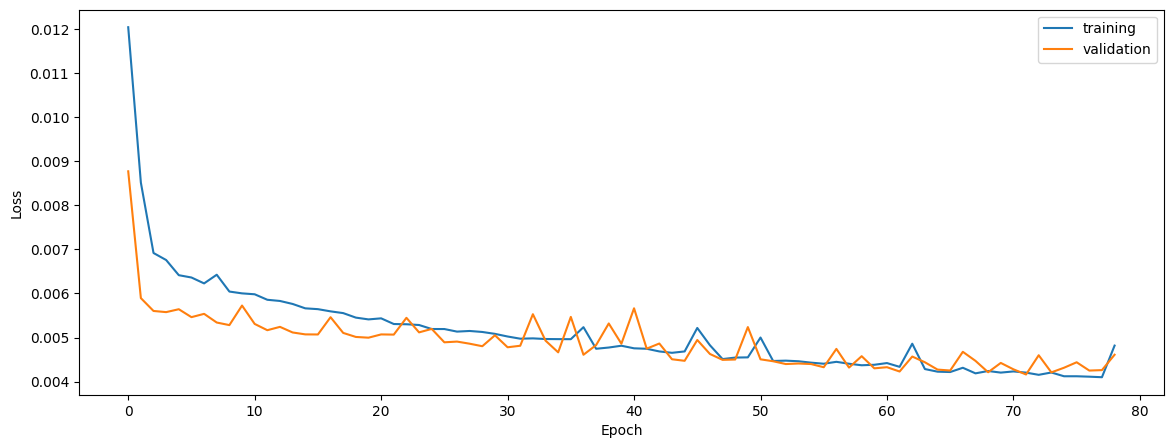

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8029167610123613
0.7719955637254695
0.712318867093546


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8029167610123613
0.7719955637254695
0.712318867093546


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8082497350175852
0.7752767731647465
0.7211692086851779


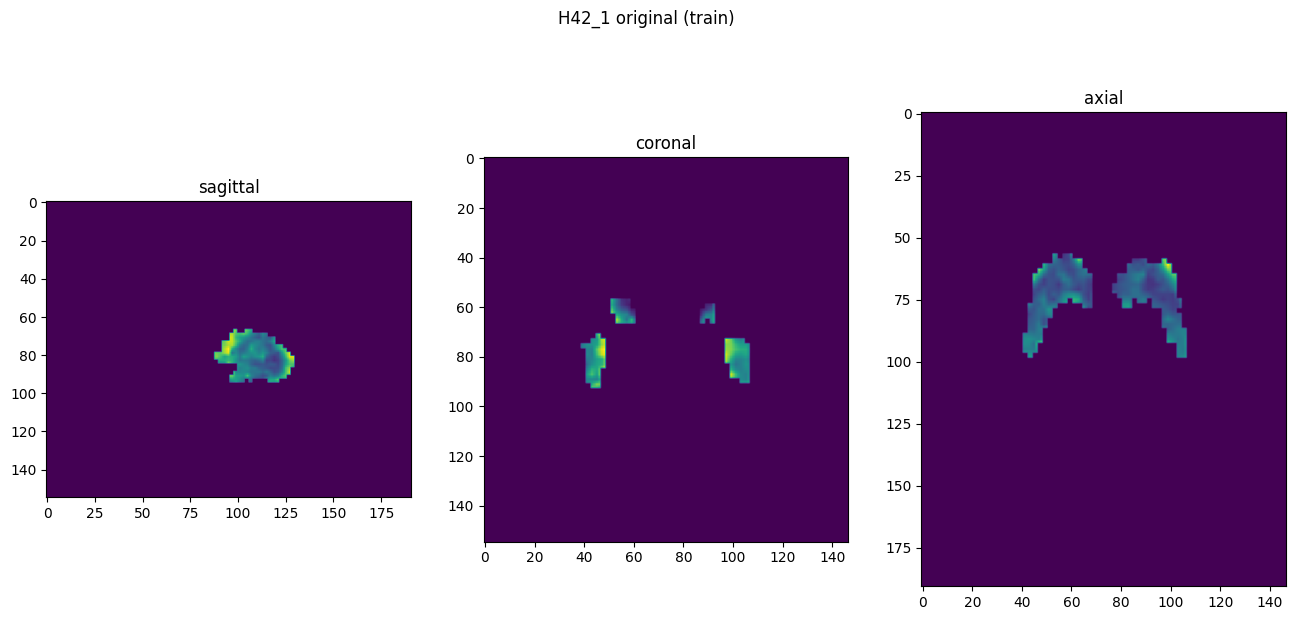

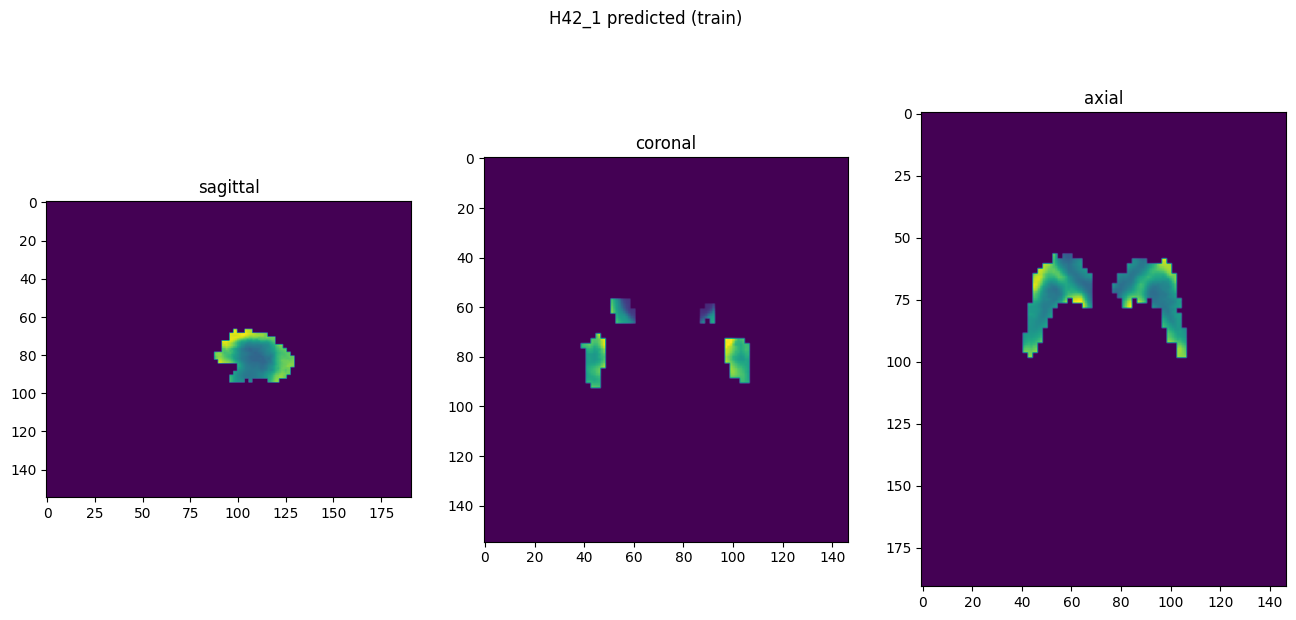

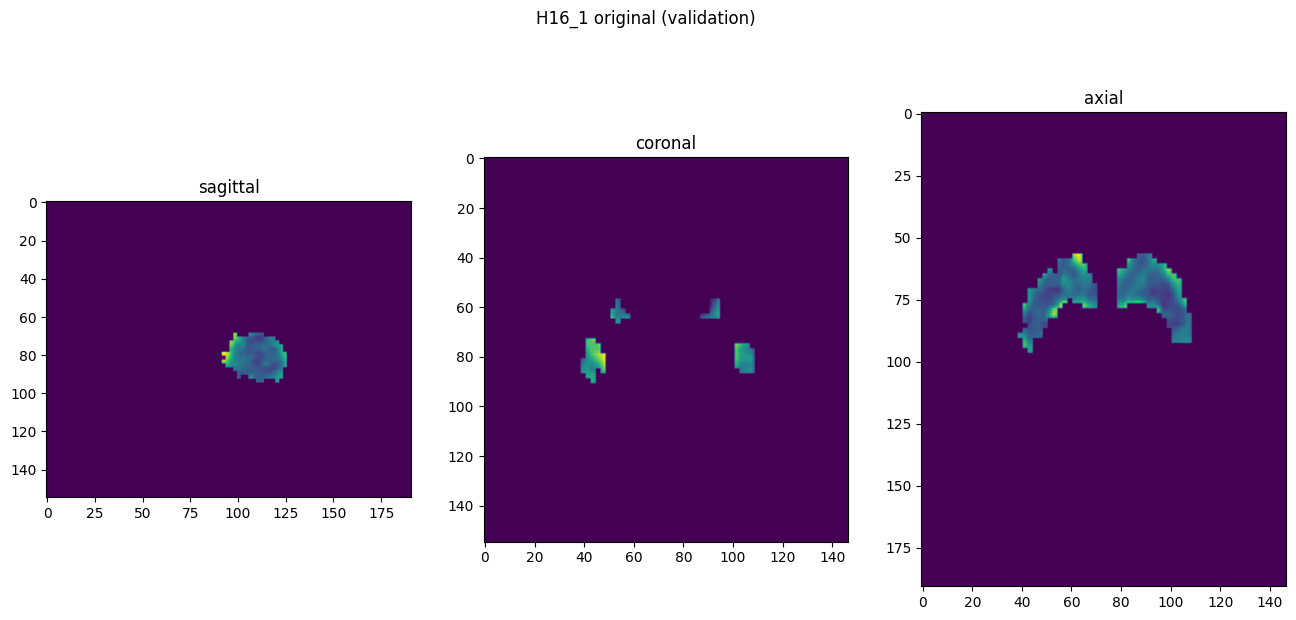

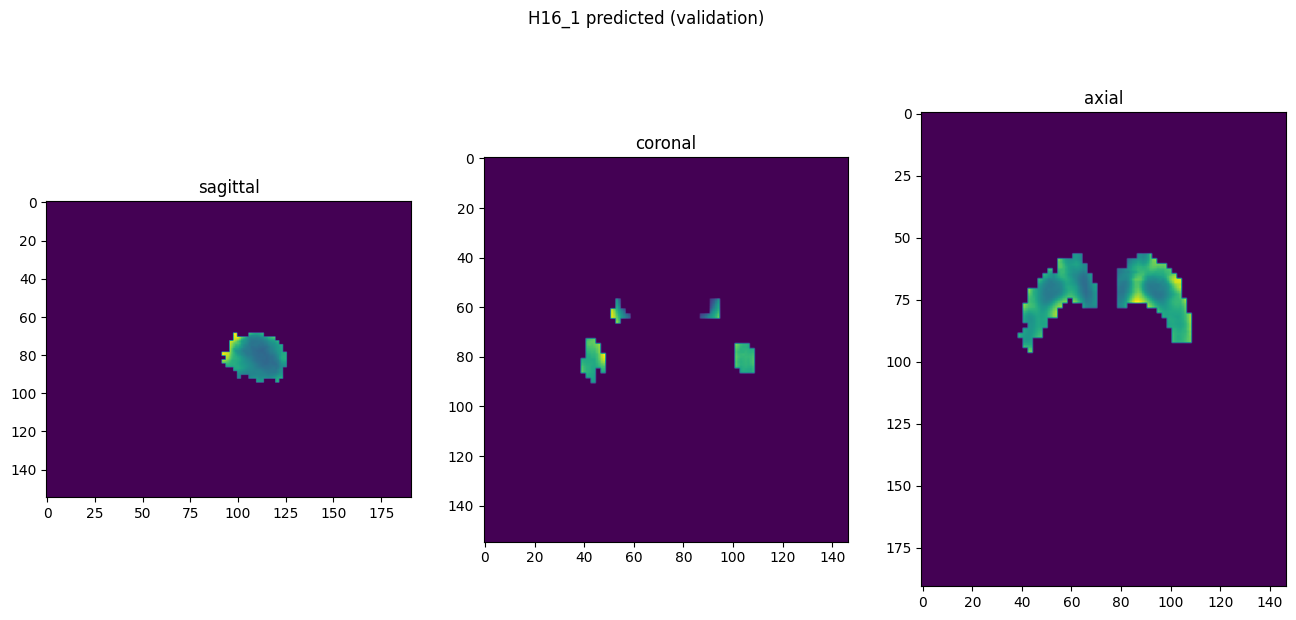

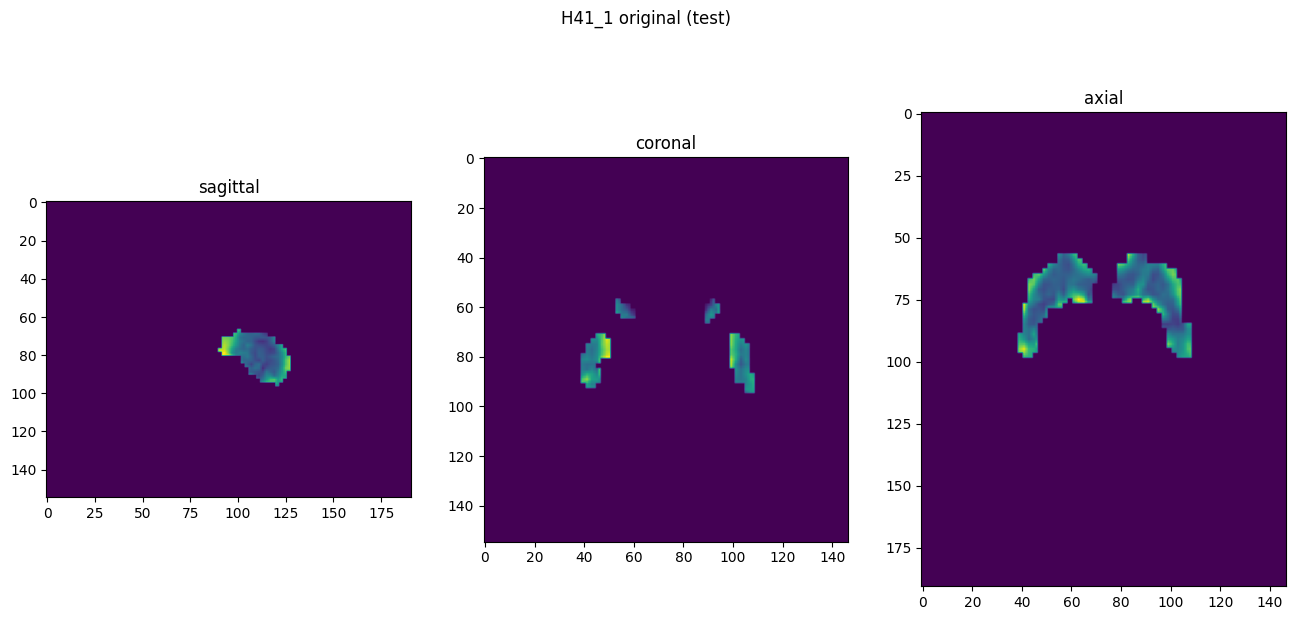

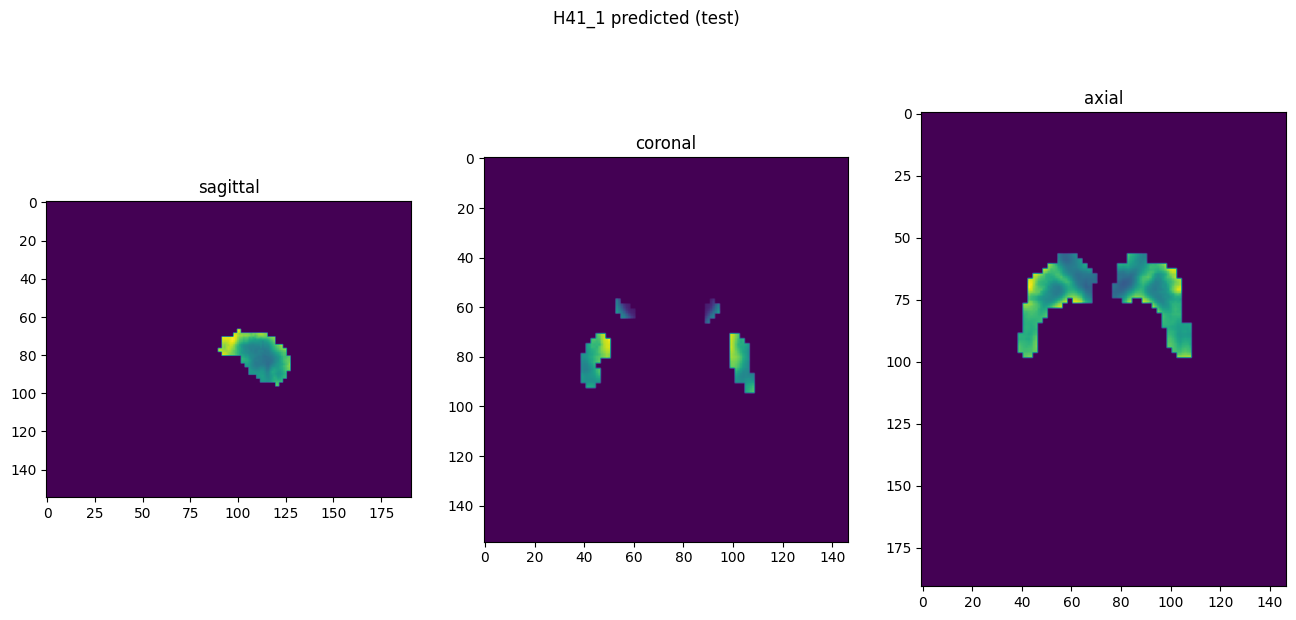

In [10]:
showResults(model, gen, threshold=None, background=False)